In [1]:
from keras_tqdm import TQDMNotebookCallback
import keras
from keras.preprocessing import image
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [3]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) # Expanding Dimension as (image_row, image_column, channel)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)    # to be compatible for tensorflow backend

x_train /= 255  # Getting input in range (0,1) to avoid instablity.
x_test /= 255

input_shape = (28, 28, 1)
num_classes = 10
batch_size = 100

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [4]:
def plot_history(history, name):
    plt.rcParams["figure.figsize"] = [15,5]
    # summarize history for loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss']), plt.plot(history.history['val_loss'])
    plt.title(name+' model loss'), plt.ylabel('loss'), plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right',prop={'size': 12})
    # summarize history for accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['acc']), plt.plot(history.history['val_acc'])
    plt.title(name+' model accuracy'), plt.ylabel('accuracy'), plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right',prop={'size': 12})
    plt.show()

#### Linear model (Logistic regression) or only sigmoid activation at last layer.

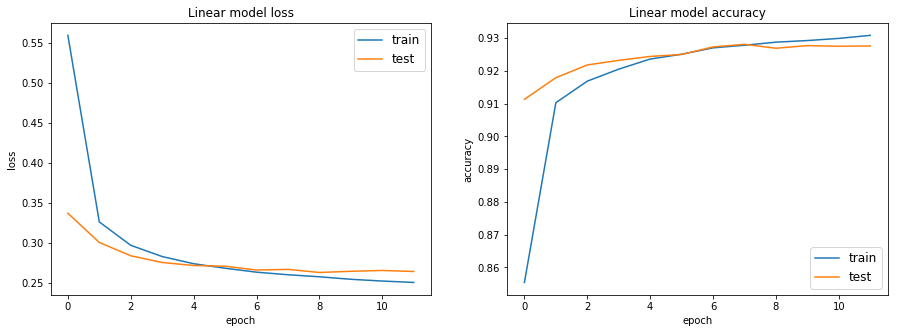

In [5]:
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(10,activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=12, batch_size=64,callbacks=[TQDMNotebookCallback(leave_inner=True)], verbose=0)
plot_history(history,'Linear')

#### Only densely connected layers

##### Single layer of 128 hidden units.

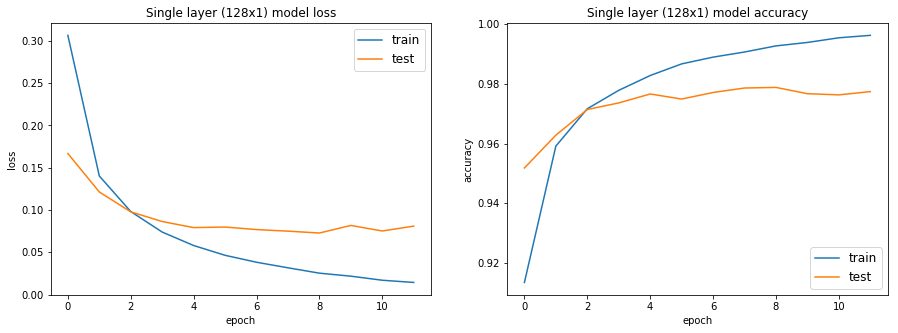

In [6]:
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(128, activation='relu'))
model.add(Dense(10,activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=12, batch_size=64,callbacks=[TQDMNotebookCallback(leave_inner=True)], verbose=0)
plot_history(history,'Single layer (128x1)')

Clearly the above model is overfitting since there is wide gap in training and test accuracy.

#### Single layer of 256 hidden units.

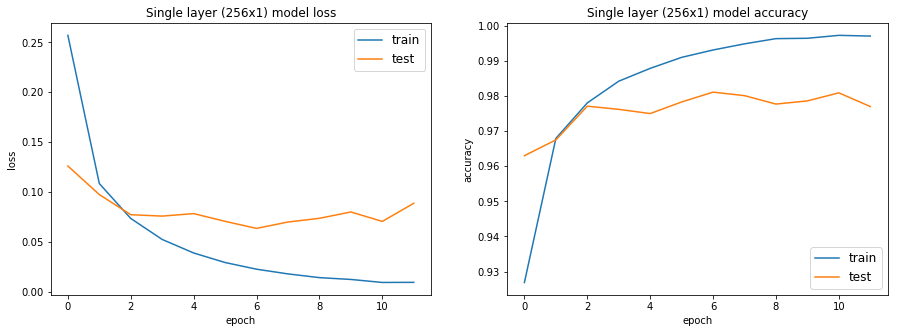

In [7]:
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(256, activation='relu'))
model.add(Dense(10,activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=12, batch_size=64,callbacks=[TQDMNotebookCallback(leave_inner=True)], verbose=0)
plot_history(history,'Single layer (256x1)')

Lets us use 256 hidden units and droput to address overfitting. 

##### Dropout = 0.2


30720/|/[loss: 0.187, acc: 0.944]  51%|| 30720/60000 [00:15<00:04, 6920.24it/s]

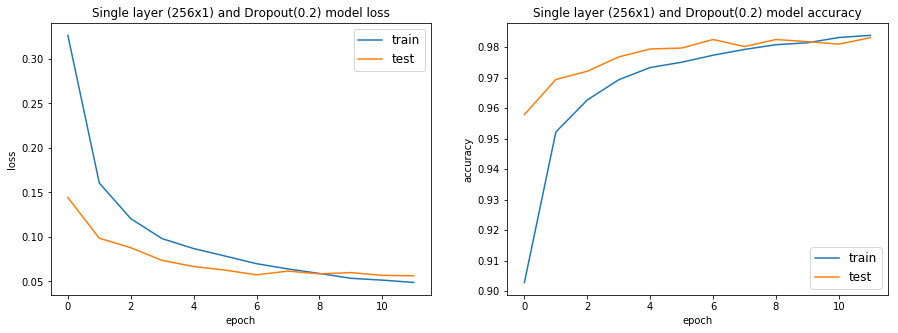

In [10]:
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10,activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=12, batch_size=64,callbacks=[TQDMNotebookCallback(leave_inner=True)], verbose=0)
plot_history(history,'Single layer (256x1) and Dropout(0.2)')

Seems better now, model isn't overfitting but we haven't reached 99% accuracy yet. Next we will try out convulation network.

##### Dropout = 0.5

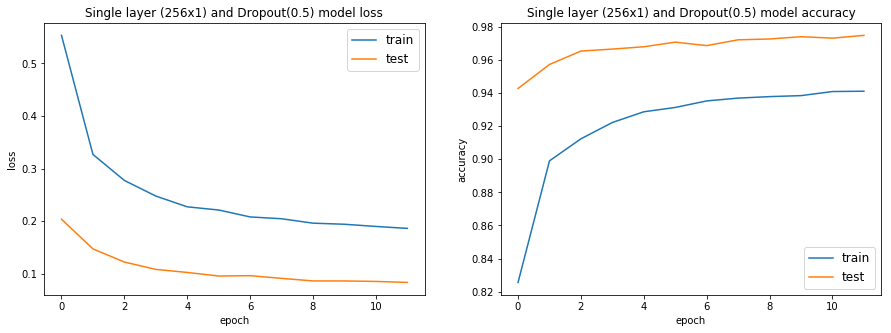

In [11]:
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=12, batch_size=64,callbacks=[TQDMNotebookCallback(leave_inner=True)], verbose=0)
plot_history(history,'Single layer (256x1) and Dropout(0.5)')

Increasing dropout seems to worsen the case and model now underfits. We will stick with 0.2 dropout.

#### Convolution Neural Network.

In [15]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=3, batch_size=64,callbacks=[TQDMNotebookCallback(leave_inner=True)], verbose=0)

Lets try adding batch normalization after activation

In [14]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=3, batch_size=64,callbacks=[TQDMNotebookCallback(leave_inner=True)], verbose=0)

Seems like it does helps to add Batch Normalization since it increased previous test accuracy of 0.988 to 0.990.

We could further improve our accuracy by adding more convulation and dense layers.